In [7]:
!nvidia-smi

Wed May 21 12:16:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060 6GB  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   42C    P8              6W /  120W |     406MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [8]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
import os
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

In [9]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


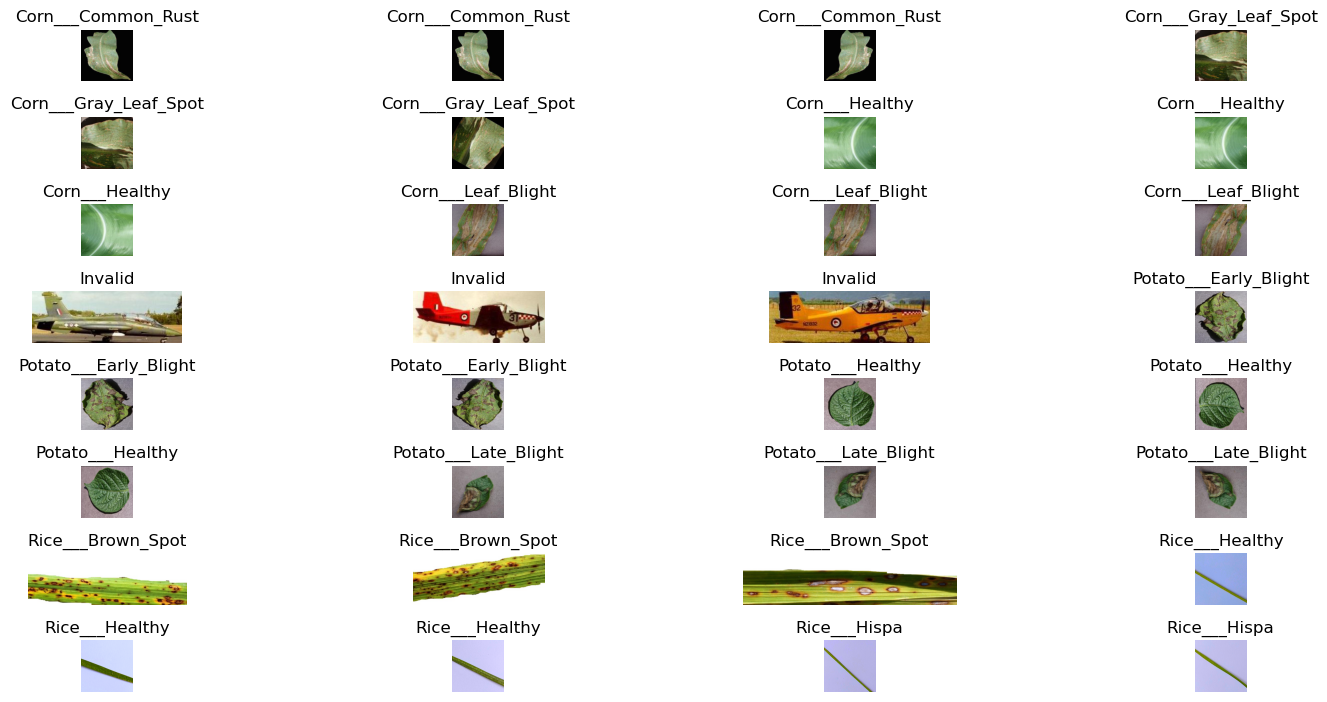

In [11]:
# Set the root path to your dataset
dataset_path = 'D:\DOCS\PYTHON\CropDisease\Crop___DIsease'  # ← change this to your actual path

# Get all class folders
class_folders = sorted(os.listdir(dataset_path))

# How many images to show
num_images_to_show = 32
images_per_row = 4

# Collect image paths and their labels
image_paths = []
labels = []

for class_name in class_folders:
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        for img_name in os.listdir(class_dir)[:3]:  # take first 3 images per class
            if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                image_paths.append(os.path.join(class_dir, img_name))
                labels.append(class_name)

# Plot using subplots
plt.figure(figsize=(15, 8))

for i in range(min(num_images_to_show, len(image_paths))):
    img = Image.open(image_paths[i])  # Open image using PIL
    img = img.convert('RGB')  # Ensure image is in RGB mode for displaying

    plt.subplot(num_images_to_show // images_per_row + 1, images_per_row, i + 1)
    plt.imshow(img)
    plt.title(labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# def find_corrupted_images(root_dir):
#     corrupted_files = []
#     supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')

#     for subdir, _, files in os.walk(root_dir):
#         for file in files:
#             if file.lower().endswith(supported_extensions):
#                 file_path = os.path.join(subdir, file)
#                 try:
#                     # Try to open and load the image
#                     with Image.open(file_path) as img:
#                         img.verify()  # verify() does not load image data but checks integrity
#                 except (IOError, SyntaxError) as e:
#                     print(f"Corrupted file detected: {file_path}")
#                     corrupted_files.append(file_path)
    
#     if not corrupted_files:
#         print("No corrupted images found!")
#     else:
#         print(f"\nTotal corrupted files found: {len(corrupted_files)}")

#     return corrupted_files

# # Change 'your_dataset_path' to your actual dataset directory
# dataset_path = r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease'
# corrupted_files = find_corrupted_images(dataset_path)

In [13]:
crop_class_map = sorted(os.listdir(r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease'))
num_class = len(crop_class_map)
print(num_class)
print(crop_class_map)

15
['Corn___Common_Rust', 'Corn___Gray_Leaf_Spot', 'Corn___Healthy', 'Corn___Leaf_Blight', 'Invalid', 'Potato___Early_Blight', 'Potato___Healthy', 'Potato___Late_Blight', 'Rice___Brown_Spot', 'Rice___Healthy', 'Rice___Hispa', 'Rice___Leaf_Blast', 'Wheat___Brown_Rust', 'Wheat___Healthy', 'Wheat___Yellow_Rust']


In [14]:
import os

def count_images_per_class(root_dir):
    supported_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff')
    class_counts = {}

    # List all folders (classes) in root_dir
    for class_name in os.listdir(root_dir):
        class_path = os.path.join(root_dir, class_name)
        if os.path.isdir(class_path):
            count = 0
            for file in os.listdir(class_path):
                if file.lower().endswith(supported_extensions):
                    count += 1
            class_counts[class_name] = count

    return class_counts

# Replace with your dataset path
dataset_path = r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease'
counts = count_images_per_class(dataset_path)

for class_name, count in counts.items():
    print(f"Class '{class_name}': {count} images")

total_images = sum(counts.values())
print(f"\nTotal images in dataset: {total_images}")

Class 'Corn___Common_Rust': 3814 images
Class 'Corn___Gray_Leaf_Spot': 3284 images
Class 'Corn___Healthy': 3718 images
Class 'Corn___Leaf_Blight': 3816 images
Class 'Invalid': 1563 images
Class 'Potato___Early_Blight': 3149 images
Class 'Potato___Healthy': 2006 images
Class 'Potato___Late_Blight': 3131 images
Class 'Rice___Brown_Spot': 563 images
Class 'Rice___Healthy': 523 images
Class 'Rice___Hispa': 523 images
Class 'Rice___Leaf_Blast': 1182 images
Class 'Wheat___Brown_Rust': 1128 images
Class 'Wheat___Healthy': 1497 images
Class 'Wheat___Yellow_Rust': 1156 images

Total images in dataset: 31053


In [15]:
from torchvision import transforms
from torch.utils.data import Dataset
from PIL import Image
import os
import torch

class CropDataset(Dataset):
    def __init__(self, root_dir, augment=False):
        self.root_dir = root_dir
        self.image_paths = []
        self.labels = []
        self.class_names = sorted(os.listdir(root_dir))
        self.augment = augment

        valid_extensions = ('.bmp', '.png', '.jpg', '.jpeg')

        # Image counts per class (make sure order matches class_names)
        class_image_counts = {
            'Corn___Common_Rust': 3814,
            'Corn___Gray_Leaf_Spot': 3284,
            'Corn___Healthy': 3718,
            'Corn___Leaf_Blight': 3816,
            'Invalid': 1563,
            'Potato___Early_Blight': 3149,
            'Potato___Healthy': 2006,
            'Potato___Late_Blight': 3131,
            'Rice___Brown_Spot': 563,
            'Rice___Healthy': 523,
            'Rice___Hispa': 523,
            'Rice___Leaf_Blast': 1182,
            'Wheat___Brown_Rust': 1128,
            'Wheat___Healthy': 1497,
            'Wheat___Yellow_Rust': 1156
        }

        # Define which classes need augmentation (threshold can be adjusted)
        self.augment_classes = {self.class_names.index(cls) for cls, count in class_image_counts.items() if count < 2000}

        for label, class_name in enumerate(self.class_names):
            class_path = os.path.join(root_dir, class_name)
            for image_name in os.listdir(class_path):
                if image_name.lower().endswith(valid_extensions):
                    image_path = os.path.join(class_path, image_name)
                    self.image_paths.append(image_path)
                    self.labels.append(label)

        # Data augmentation transformations
        self.augmentation_transforms = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.2),
            transforms.RandomRotation(degrees=20),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0))
        ])

        # Standard preprocessing transformations
        self.preprocess_transforms = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
    
        try:
            image = Image.open(image_path).convert("RGB")
    
            # Apply augmentation only if enabled AND class is in augment_classes
            if self.augment and label in self.augment_classes:
                image = self.augmentation_transforms(image)
    
            # Apply standard preprocessing (resize, normalize, etc.)
            image = self.preprocess_transforms(image)
    
        except Exception as e:
            raise ValueError(f"Failed to load image: {image_path} — {e}")
    
        return image, torch.tensor(label, dtype=torch.long)

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset, DataLoader
import numpy as np
import random
import torch
import pickle

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Generator for reproducibility
g = torch.Generator()
g.manual_seed(42)

# ✅ Load full dataset without augmentation
full_dataset = CropDataset(root_dir=r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease', augment=False)
labels = full_dataset.labels

# ✅ Stratified split: Train / Val / Test
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15
total_size = len(labels)

# First split: Train vs Temp (val+test)
sss = StratifiedShuffleSplit(n_splits=1, test_size=(1 - train_ratio), random_state=42)
train_idx, temp_idx = next(sss.split(np.zeros(total_size), labels))

# Second split: Val vs Test
temp_labels = np.array(labels)[temp_idx]
sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_idx)), temp_labels))

# Map back to original indices
val_idx = np.array(temp_idx)[val_idx]
test_idx = np.array(temp_idx)[test_idx]

# ✅ Create dataset splits
train_dataset = CropDataset(root_dir=r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease', augment=True)
train_dataset = Subset(train_dataset, train_idx)

val_dataset = CropDataset(root_dir=r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease', augment=False)
val_dataset = Subset(val_dataset, val_idx)

test_dataset = CropDataset(root_dir=r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease', augment=False)
test_dataset = Subset(test_dataset, test_idx)

# ✅ Create DataLoaders (optimized)
batch_size = 32
num_workers = 0  # Adjust based on your CPU cores

full_train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=True, worker_init_fn=seed_worker, generator=g
)

full_val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, worker_init_fn=seed_worker, generator=g
)

full_test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=True, worker_init_fn=seed_worker, generator=g
)

# ✅ Optional sanity check
print(f"Total: {total_size}, Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

# ================== Save Test Split ==================

# Path to save the test split indices
test_split_path = 'FINAL_test_split_indices.pkl'

# Save the test indices
with open(test_split_path, 'wb') as f:
    pickle.dump(list(test_idx), f)

print(f"Test split indices saved to {test_split_path}")

Total: 31053, Train: 21737, Val: 4658, Test: 4658
Test split indices saved to FINAL_test_split_indices.pkl


In [17]:
# # ================== Dataset Split Consistency Check ==================

# # Function to split dataset and track splits
# def get_splits(dataset):
#     labels = dataset.labels
#     total_size = len(labels)

#     # First split: Train vs Temp (val+test)
#     sss = StratifiedShuffleSplit(n_splits=1, test_size=(1 - train_ratio), random_state=42)
#     train_idx, temp_idx = next(sss.split(np.zeros(total_size), labels))

#     # Second split: Val vs Test
#     temp_labels = np.array(labels)[temp_idx]
#     sss_val_test = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
#     val_idx, test_idx = next(sss_val_test.split(np.zeros(len(temp_idx)), temp_labels))

#     # Map back to original indices
#     val_idx = np.array(temp_idx)[val_idx]
#     test_idx = np.array(temp_idx)[test_idx]

#     train_images = sorted([dataset.image_paths[i] for i in train_idx])
#     val_images = sorted([dataset.image_paths[i] for i in val_idx])
#     test_images = sorted([dataset.image_paths[i] for i in test_idx])

#     return train_images, val_images, test_images

# # Reference split to compare against
# ref_train, ref_val, ref_test = get_splits(full_dataset)

# # Number of iterations to run
# num_iterations = 1000

# # Checking consistency across multiple runs
# for iteration in range(num_iterations):
#     current_train, current_val, current_test = get_splits(full_dataset)

#     if current_train != ref_train or current_val != ref_val or current_test != ref_test:
#         print(f"Inconsistency found in iteration {iteration}")
#         break
# else:
#     print("All splits are consistent across 1000 iterations")

In [18]:
# import shutil
# import os

# # Clear checkpoints
# shutil.rmtree('checkpoints', ignore_errors=True)
# os.makedirs('checkpoints', exist_ok=True)

# # Remove Optuna study database
# db_path = "optuna_study.db"
# if os.path.exists(db_path):
#     os.remove(db_path)

# print("Checkpoints and Optuna study cleared.")

In [19]:
import optuna
from optuna.samplers import TPESampler
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.models as models
import os
import pickle
import gc  # For garbage collection

class EfficientNetFineTune(nn.Module):
    def __init__(self, num_class, hidden_units, dropout_rate):
        super().__init__()

        # Load the pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Get the input features of the fully connected layer
        in_features = self.efficientnet.classifier[1].in_features

        # Modify the fully connected layer with custom hidden units and dropout rate
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(in_features, hidden_units),  # Custom hidden layer
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),  # Activation function
            nn.Dropout(dropout_rate),  # Dropout for regularization

            nn.Linear(hidden_units, num_class)
        )

    def forward(self, x):
        return self.efficientnet(x)

def objective(trial):
    try:
        print(f"Starting trial {trial.number}...")
        
        lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
        dropout_rate = trial.suggest_float("dropout", 0.2, 0.6)
        optimizer_name = trial.suggest_categorical("optimizer", ["SGD", "Adam", "AdamW", "RMSprop"])
        hidden_units = trial.suggest_int("hidden_units", 128, 1024, step=128)

        print(f"Hyperparams - lr: {lr:.6f}, dropout: {dropout_rate:.2f}, optimizer: {optimizer_name}, hidden: {hidden_units}")

        model = EfficientNetFineTune(num_class=num_class, hidden_units=hidden_units, dropout_rate=dropout_rate).to(device)
        criterion = nn.CrossEntropyLoss()

        if optimizer_name == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
        elif optimizer_name == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
        elif optimizer_name == "AdamW":
            optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        elif optimizer_name == "RMSprop":
            optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-4)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer_name}")

        checkpoint_dir = 'checkpoints'
        os.makedirs(checkpoint_dir, exist_ok=True)
        checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_trial_{trial.number}.pth")
        best_accuracy = 0.0

        if os.path.exists(checkpoint_path):
            print(f"Resuming from checkpoint for trial {trial.number}...")
            checkpoint = torch.load(checkpoint_path)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            best_accuracy = checkpoint['best_accuracy']

        print("Training...")
        for epoch in range(3):
            model.train()
            total_loss = 0
            for images, labels in full_train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            avg_train_loss = total_loss / len(full_train_loader)
            print(f"Epoch [{epoch+1}/3], Train Loss: {avg_train_loss:.4f}")

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in full_val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            accuracy = correct / total
            print(f"Epoch [{epoch+1}/3], Validation Accuracy: {accuracy:.4f}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_accuracy': best_accuracy
                }
                torch.save(checkpoint, checkpoint_path)
                print(f"Checkpoint saved for trial {trial.number} at epoch {epoch+1}")

            trial.report(1.0 - accuracy, step=epoch)

            torch.cuda.empty_cache()
            gc.collect()

        return 1.0 - best_accuracy

    except torch.cuda.OutOfMemoryError:
        error_msg = "Out of Memory"
        print(f"Trial {trial.number} pruned: {error_msg}")
        trial.set_user_attr("skip_reason", error_msg)
        torch.cuda.empty_cache()
        gc.collect()
        raise optuna.exceptions.TrialPruned()

    except Exception as e:
        error_msg = str(e)
        print(f"Trial {trial.number} failed: {error_msg}")
        trial.set_user_attr("skip_reason", error_msg)
        raise optuna.exceptions.TrialPruned()

    finally:
        del model
        del optimizer
        torch.cuda.empty_cache()
        gc.collect()

# Optuna study setup
db_path = "optuna_study.db"
study = optuna.load_study(study_name="resnet_study", storage=f"sqlite:///{db_path}") if os.path.exists(db_path) else \
        optuna.create_study(study_name="resnet_study", direction="minimize", sampler=TPESampler(seed=42), storage=f"sqlite:///{db_path}")

print("Starting Optuna study...")
study.optimize(objective, n_trials=20)

print("\nBest trial:")
best_trial = study.best_trial
print(f"  Value: {best_trial.value}")
print(f"  Params: {best_trial.params}")

# Check for skipped/pruned trials and their reasons
print("\nSkipped Trials Report:")
for trial in study.get_trials(states=[optuna.trial.TrialState.PRUNED]):
    reason = trial.user_attrs.get("skip_reason", "Unknown reason")
    print(f"Trial {trial.number}: {reason}")

print("Completed Optuna study with logging of skipped trials.")

Starting Optuna study...
Starting trial 10...
Hyperparams - lr: 0.004162, dropout: 0.23, optimizer: AdamW, hidden: 128


C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training...
Epoch [1/3], Train Loss: 0.4258
Epoch [1/3], Validation Accuracy: 0.8697
Checkpoint saved for trial 10 at epoch 1
Epoch [2/3], Train Loss: 0.2688
Epoch [2/3], Validation Accuracy: 0.9279
Checkpoint saved for trial 10 at epoch 2
Epoch [3/3], Train Loss: 0.2324
Epoch [3/3], Validation Accuracy: 0.9281
Checkpoint saved for trial 10 at epoch 3


[I 2025-05-21 13:38:01,196] Trial 10 finished with value: 0.07191927866036929 and parameters: {'lr': 0.004162175175219467, 'dropout': 0.2318472760415396, 'optimizer': 'AdamW', 'hidden_units': 128}. Best is trial 1 with value: 0.021683125805066594.


Starting trial 11...
Hyperparams - lr: 0.001253, dropout: 0.59, optimizer: SGD, hidden: 896
Training...
Epoch [1/3], Train Loss: 0.3968
Epoch [1/3], Validation Accuracy: 0.9532
Checkpoint saved for trial 11 at epoch 1
Epoch [2/3], Train Loss: 0.1509
Epoch [2/3], Validation Accuracy: 0.9678
Checkpoint saved for trial 11 at epoch 2
Epoch [3/3], Train Loss: 0.1169
Epoch [3/3], Validation Accuracy: 0.9714
Checkpoint saved for trial 11 at epoch 3


[I 2025-05-21 14:53:15,083] Trial 11 finished with value: 0.0285530270502361 and parameters: {'lr': 0.001253184174713206, 'dropout': 0.5856999723732319, 'optimizer': 'SGD', 'hidden_units': 896}. Best is trial 1 with value: 0.021683125805066594.


Starting trial 12...
Hyperparams - lr: 0.000490, dropout: 0.27, optimizer: AdamW, hidden: 1024
Training...
Epoch [1/3], Train Loss: 0.2101
Epoch [1/3], Validation Accuracy: 0.9626
Checkpoint saved for trial 12 at epoch 1
Epoch [2/3], Train Loss: 0.1200
Epoch [2/3], Validation Accuracy: 0.9745
Checkpoint saved for trial 12 at epoch 2
Epoch [3/3], Train Loss: 0.0962
Epoch [3/3], Validation Accuracy: 0.9717


[I 2025-05-21 16:08:23,262] Trial 12 finished with value: 0.025547445255474477 and parameters: {'lr': 0.0004896632069012873, 'dropout': 0.266794226905557, 'optimizer': 'AdamW', 'hidden_units': 1024}. Best is trial 1 with value: 0.021683125805066594.


Starting trial 13...
Hyperparams - lr: 0.000975, dropout: 0.47, optimizer: AdamW, hidden: 512
Training...
Epoch [1/3], Train Loss: 0.2539
Epoch [1/3], Validation Accuracy: 0.9534
Checkpoint saved for trial 13 at epoch 1
Epoch [2/3], Train Loss: 0.1534
Epoch [2/3], Validation Accuracy: 0.9687
Checkpoint saved for trial 13 at epoch 2
Epoch [3/3], Train Loss: 0.1276
Epoch [3/3], Validation Accuracy: 0.9590


[I 2025-05-21 17:23:29,936] Trial 13 finished with value: 0.031343924431086356 and parameters: {'lr': 0.0009753677357065088, 'dropout': 0.4731463479566883, 'optimizer': 'AdamW', 'hidden_units': 512}. Best is trial 1 with value: 0.021683125805066594.


Starting trial 14...
Hyperparams - lr: 0.000462, dropout: 0.52, optimizer: RMSprop, hidden: 512
Training...
Epoch [1/3], Train Loss: 0.2337
Epoch [1/3], Validation Accuracy: 0.9300
Checkpoint saved for trial 14 at epoch 1
Epoch [2/3], Train Loss: 0.1447
Epoch [2/3], Validation Accuracy: 0.9294
Epoch [3/3], Train Loss: 0.1156
Epoch [3/3], Validation Accuracy: 0.9611
Checkpoint saved for trial 14 at epoch 3


[I 2025-05-21 18:38:30,379] Trial 14 finished with value: 0.03885787891799053 and parameters: {'lr': 0.00046180967094276774, 'dropout': 0.5161769778690751, 'optimizer': 'RMSprop', 'hidden_units': 512}. Best is trial 1 with value: 0.021683125805066594.


Starting trial 15...
Hyperparams - lr: 0.001416, dropout: 0.59, optimizer: SGD, hidden: 768
Training...
Epoch [1/3], Train Loss: 0.3834
Epoch [1/3], Validation Accuracy: 0.9556
Checkpoint saved for trial 15 at epoch 1
Epoch [2/3], Train Loss: 0.1434
Epoch [2/3], Validation Accuracy: 0.9695
Checkpoint saved for trial 15 at epoch 2
Epoch [3/3], Train Loss: 0.1067
Epoch [3/3], Validation Accuracy: 0.9697
Checkpoint saved for trial 15 at epoch 3


[I 2025-05-21 19:53:18,722] Trial 15 finished with value: 0.030270502361528506 and parameters: {'lr': 0.0014161756639934986, 'dropout': 0.5855792654714774, 'optimizer': 'SGD', 'hidden_units': 768}. Best is trial 1 with value: 0.021683125805066594.


Starting trial 16...
Hyperparams - lr: 0.000382, dropout: 0.43, optimizer: AdamW, hidden: 384
Training...
Epoch [1/3], Train Loss: 0.2311
Epoch [1/3], Validation Accuracy: 0.9568
Checkpoint saved for trial 16 at epoch 1
Epoch [2/3], Train Loss: 0.1156
Epoch [2/3], Validation Accuracy: 0.9757
Checkpoint saved for trial 16 at epoch 2
Epoch [3/3], Train Loss: 0.0965
Epoch [3/3], Validation Accuracy: 0.9751


[I 2025-05-21 21:07:59,882] Trial 16 finished with value: 0.024259338772005146 and parameters: {'lr': 0.0003815755609668221, 'dropout': 0.43357382172367465, 'optimizer': 'AdamW', 'hidden_units': 384}. Best is trial 1 with value: 0.021683125805066594.


Starting trial 17...
Hyperparams - lr: 0.002100, dropout: 0.53, optimizer: SGD, hidden: 768
Training...
Epoch [1/3], Train Loss: 0.3174
Epoch [1/3], Validation Accuracy: 0.9676
Checkpoint saved for trial 17 at epoch 1
Epoch [2/3], Train Loss: 0.1260
Epoch [2/3], Validation Accuracy: 0.9757
Checkpoint saved for trial 17 at epoch 2
Epoch [3/3], Train Loss: 0.0949
Epoch [3/3], Validation Accuracy: 0.9751


[I 2025-05-21 22:22:31,712] Trial 17 finished with value: 0.024259338772005146 and parameters: {'lr': 0.002100436936639049, 'dropout': 0.530512060896542, 'optimizer': 'SGD', 'hidden_units': 768}. Best is trial 1 with value: 0.021683125805066594.


Starting trial 18...
Hyperparams - lr: 0.000101, dropout: 0.45, optimizer: AdamW, hidden: 384
Training...
Epoch [1/3], Train Loss: 0.3658
Epoch [1/3], Validation Accuracy: 0.9650
Checkpoint saved for trial 18 at epoch 1
Epoch [2/3], Train Loss: 0.1223
Epoch [2/3], Validation Accuracy: 0.9704
Checkpoint saved for trial 18 at epoch 2
Epoch [3/3], Train Loss: 0.0912
Epoch [3/3], Validation Accuracy: 0.9785
Checkpoint saved for trial 18 at epoch 3


[I 2025-05-21 23:37:09,598] Trial 18 finished with value: 0.021468441391155002 and parameters: {'lr': 0.00010104760463620267, 'dropout': 0.44544429180592154, 'optimizer': 'AdamW', 'hidden_units': 384}. Best is trial 18 with value: 0.021468441391155002.


Starting trial 19...
Hyperparams - lr: 0.000108, dropout: 0.43, optimizer: AdamW, hidden: 384
Training...
Epoch [1/3], Train Loss: 0.3532
Epoch [1/3], Validation Accuracy: 0.9678
Checkpoint saved for trial 19 at epoch 1
Epoch [2/3], Train Loss: 0.1143
Epoch [2/3], Validation Accuracy: 0.9738
Checkpoint saved for trial 19 at epoch 2
Epoch [3/3], Train Loss: 0.0870
Epoch [3/3], Validation Accuracy: 0.9753
Checkpoint saved for trial 19 at epoch 3


[I 2025-05-22 00:53:49,235] Trial 19 finished with value: 0.02468870759982822 and parameters: {'lr': 0.00010799074202041919, 'dropout': 0.4339093432142083, 'optimizer': 'AdamW', 'hidden_units': 384}. Best is trial 18 with value: 0.021468441391155002.


Starting trial 20...
Hyperparams - lr: 0.000103, dropout: 0.33, optimizer: AdamW, hidden: 256
Training...
Epoch [1/3], Train Loss: 0.4002
Epoch [1/3], Validation Accuracy: 0.9687
Checkpoint saved for trial 20 at epoch 1
Epoch [2/3], Train Loss: 0.1267
Epoch [2/3], Validation Accuracy: 0.9768
Checkpoint saved for trial 20 at epoch 2
Epoch [3/3], Train Loss: 0.0906
Epoch [3/3], Validation Accuracy: 0.9779
Checkpoint saved for trial 20 at epoch 3


[I 2025-05-22 02:09:34,028] Trial 20 finished with value: 0.022112494632889668 and parameters: {'lr': 0.00010348072597288479, 'dropout': 0.32982881248099716, 'optimizer': 'AdamW', 'hidden_units': 256}. Best is trial 18 with value: 0.021468441391155002.


Starting trial 21...
Hyperparams - lr: 0.000262, dropout: 0.46, optimizer: AdamW, hidden: 640
Training...
Epoch [1/3], Train Loss: 0.2264
Epoch [1/3], Validation Accuracy: 0.9609
Checkpoint saved for trial 21 at epoch 1
Epoch [2/3], Train Loss: 0.1093
Epoch [2/3], Validation Accuracy: 0.9742
Checkpoint saved for trial 21 at epoch 2
Epoch [3/3], Train Loss: 0.0873
Epoch [3/3], Validation Accuracy: 0.9736


[I 2025-05-22 03:26:49,854] Trial 21 finished with value: 0.025762129669385958 and parameters: {'lr': 0.00026178514444777964, 'dropout': 0.46322799757374417, 'optimizer': 'AdamW', 'hidden_units': 640}. Best is trial 18 with value: 0.021468441391155002.


Starting trial 22...
Hyperparams - lr: 0.000713, dropout: 0.55, optimizer: AdamW, hidden: 256
Training...
Epoch [1/3], Train Loss: 0.2593
Epoch [1/3], Validation Accuracy: 0.9592
Checkpoint saved for trial 22 at epoch 1
Epoch [2/3], Train Loss: 0.1528
Epoch [2/3], Validation Accuracy: 0.9652
Checkpoint saved for trial 22 at epoch 2
Epoch [3/3], Train Loss: 0.1197
Epoch [3/3], Validation Accuracy: 0.9674
Checkpoint saved for trial 22 at epoch 3


[I 2025-05-22 04:42:25,110] Trial 22 finished with value: 0.032632030914555576 and parameters: {'lr': 0.0007133009052345603, 'dropout': 0.5481335048702921, 'optimizer': 'AdamW', 'hidden_units': 256}. Best is trial 18 with value: 0.021468441391155002.


Starting trial 23...
Hyperparams - lr: 0.000104, dropout: 0.30, optimizer: AdamW, hidden: 256
Training...
Epoch [1/3], Train Loss: 0.3966
Epoch [1/3], Validation Accuracy: 0.9689
Checkpoint saved for trial 23 at epoch 1
Epoch [2/3], Train Loss: 0.1222
Epoch [2/3], Validation Accuracy: 0.9736
Checkpoint saved for trial 23 at epoch 2
Epoch [3/3], Train Loss: 0.0908
Epoch [3/3], Validation Accuracy: 0.9749
Checkpoint saved for trial 23 at epoch 3


[I 2025-05-22 05:57:51,389] Trial 23 finished with value: 0.025118076427651403 and parameters: {'lr': 0.00010367416170405978, 'dropout': 0.3018588706723595, 'optimizer': 'AdamW', 'hidden_units': 256}. Best is trial 18 with value: 0.021468441391155002.


Starting trial 24...
Hyperparams - lr: 0.000289, dropout: 0.32, optimizer: AdamW, hidden: 384
Training...
Epoch [1/3], Train Loss: 0.2361
Epoch [1/3], Validation Accuracy: 0.9691
Checkpoint saved for trial 24 at epoch 1
Epoch [2/3], Train Loss: 0.1031
Epoch [2/3], Validation Accuracy: 0.9749
Checkpoint saved for trial 24 at epoch 2
Epoch [3/3], Train Loss: 0.0886
Epoch [3/3], Validation Accuracy: 0.9717


[I 2025-05-22 07:13:31,896] Trial 24 finished with value: 0.025118076427651403 and parameters: {'lr': 0.0002888027159298351, 'dropout': 0.32045531499232277, 'optimizer': 'AdamW', 'hidden_units': 384}. Best is trial 18 with value: 0.021468441391155002.


Starting trial 25...
Hyperparams - lr: 0.000100, dropout: 0.40, optimizer: AdamW, hidden: 256
Training...


[W 2025-05-22 07:20:14,888] Trial 25 failed with parameters: {'lr': 0.00010014762509851828, 'dropout': 0.399591431583762, 'optimizer': 'AdamW', 'hidden_units': 256} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Mushfiq\AppData\Local\Temp\ipykernel_17220\3325434957.py", line 75, in objective
    for images, labels in full_train_loader:
  File "C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\torch\utils\data\dataloader.py", line 701, in __next__
    data = self._next_data()
  File "C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\torch\utils\data\dataloader.py", line 757, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
  File "C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\torch\utils\data\_utils\fetch.py", line 50, in fetch
    dat

KeyboardInterrupt: 

In [20]:
completed_trials = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
remaining_trials = 20 - completed_trials
print(f"Already completed trials: {completed_trials}")
print(f"Trials that will run now: {remaining_trials}")

Already completed trials: 23
Trials that will run now: -3


In [21]:
import sqlite3

conn = sqlite3.connect("optuna_study.db")
cursor = conn.cursor()
cursor.execute("SELECT trial_id, state FROM trials")
print(cursor.fetchall())
conn.close()

[(1, 'FAIL'), (2, 'COMPLETE'), (3, 'COMPLETE'), (4, 'COMPLETE'), (5, 'COMPLETE'), (6, 'COMPLETE'), (7, 'COMPLETE'), (8, 'COMPLETE'), (9, 'COMPLETE'), (10, 'RUNNING'), (11, 'COMPLETE'), (12, 'COMPLETE'), (13, 'COMPLETE'), (14, 'COMPLETE'), (15, 'COMPLETE'), (16, 'COMPLETE'), (17, 'COMPLETE'), (18, 'COMPLETE'), (19, 'COMPLETE'), (20, 'COMPLETE'), (21, 'COMPLETE'), (22, 'COMPLETE'), (23, 'COMPLETE'), (24, 'COMPLETE'), (25, 'COMPLETE'), (26, 'FAIL')]


In [23]:
import optuna

# Load the existing study from the SQLite database
study = optuna.load_study(study_name="resnet_study", storage="sqlite:///optuna_study.db")

# Access the best trial
best_trial = study.best_trial

# Now you can safely use:
best_params = best_trial.params
print(best_params)

{'lr': 0.00010104760463620267, 'dropout': 0.44544429180592154, 'optimizer': 'AdamW', 'hidden_units': 384}


In [24]:
best_params = best_trial.params
print(best_params)
lr = best_params['lr']
dropout_rate = best_params['dropout']
optimizer_name = best_params['optimizer']
hidden_units = best_params['hidden_units']
epochs = 30

{'lr': 0.00010104760463620267, 'dropout': 0.44544429180592154, 'optimizer': 'AdamW', 'hidden_units': 384}


In [25]:
import torch.nn as nn
import torchvision.models as models

class EfficientNetFineTune(nn.Module):
    def __init__(self, num_class, hidden_units, dropout_rate):
        super().__init__()

        # Load the pre-trained EfficientNet model
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Get the input features of the fully connected layer
        in_features = self.efficientnet.classifier[1].in_features

        # Modify the fully connected layer with custom hidden units and dropout rate
        self.efficientnet.classifier = nn.Sequential(
            nn.Linear(in_features, hidden_units),  # Custom hidden layer
            nn.BatchNorm1d(hidden_units),
            nn.ReLU(),  # Activation function
            nn.Dropout(dropout_rate),  # Dropout for regularization

            nn.Linear(hidden_units, num_class)
        )

    def forward(self, x):
        return self.efficientnet(x)

In [27]:
from torchsummary import summary
# Define class counts (same as in CropDataset)
class_counts = [3814, 3284, 3718, 3816, 1563, 3149, 2006, 3131, 563, 523, 523, 1182, 1128, 1497, 1156]

# Calculate class weights (inverse frequency)
class_weights = torch.tensor([1.0 / count for count in class_counts], dtype=torch.float).to(device)

model = EfficientNetFineTune(num_class=num_class, hidden_units=hidden_units, dropout_rate=dropout_rate).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Add class weights to loss

# Print model summary
summary(model, input_size=(3, 224, 224))

# Initialize optimizer based on Optuna's best optimizer
if optimizer_name == "SGD":
    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4, momentum=0.9)
elif optimizer_name == "Adam":
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
elif optimizer_name == "AdamW":
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
elif optimizer_name == "RMSprop":
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-4)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

# Learning rate scheduler (same as original code)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

C:\Users\Mushfiq\anaconda3\envs\PT\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [28]:
!nvidia-smi

Thu May 22 07:24:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1060 6GB  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   49C    P8              6W /  120W |     784MiB /   6144MiB |      2%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [29]:
import os

# Paths to your checkpoint and best model
checkpoint_path = "checkpoint.pth"
best_model_path = "best_model.pth"

# Check if the checkpoint file exists and remove it
if os.path.exists(checkpoint_path):
    print(f"Deleting old checkpoint: {checkpoint_path}")
    os.remove(checkpoint_path)

# Check if the best model file exists and remove it
if os.path.exists(best_model_path):
    print(f"Deleting old best model: {best_model_path}")
    os.remove(best_model_path)

# Optionally, if you want to clear any other unnecessary files, add them here
# Example: os.remove("another_checkpoint.pth")

print("Old checkpoints deleted. Ready to start fresh training.")

Old checkpoints deleted. Ready to start fresh training.


In [31]:
import time
from tqdm import tqdm
# Initialize lists for tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')

# File paths
checkpoint_path = "FINAL_crop_checkpoint_optuna.pth"
best_model_path = "FINAL_crop_best_model_efficientNet_optuna.pth"
final_model_path = "FINAL_crop_final_model_efficientNet_optuna.pth"
final_weights_path = "FINAL_crop_final_weights_efficientNet_optuna.pth"

# Early stopping parameters
patience = 5
early_stop_counter = 0
start_epoch = 0

# Check if a checkpoint exists
if os.path.exists(checkpoint_path):
    print("Resuming training from the last checkpoint...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_val_loss = checkpoint['best_val_loss']
    early_stop_counter = checkpoint['early_stop_counter']
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    # Load accuracies if present
    train_accuracies = checkpoint.get('train_accuracies', [])
    val_accuracies = checkpoint.get('val_accuracies', [])
    # Load class weights if saved
    if 'class_weights' in checkpoint:
        class_weights = checkpoint['class_weights'].to(device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(f"Resumed from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting training from scratch...")

for epoch in range(start_epoch, epochs):
    start_time = time.time()
    print(f"Epoch {epoch+1}/{epochs} started")
    
    # Training Phase
    model.train()
    print('Training...')
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for batch_features, batch_labels in tqdm(full_train_loader, desc='Training', leave=False):
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)  # Weighted loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_labels.size(0)
        correct_train += (predicted == batch_labels).sum().item()

    avg_train_loss = total_train_loss / len(full_train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation Phase
    model.eval()  # Fixed: Added parentheses
    print('Validating...')
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_features, val_labels in tqdm(full_val_loader, desc='Validating', leave=False):
            val_features, val_labels = val_features.to(device), val_labels.to(device)
            val_outputs = model(val_features)
            val_loss = criterion(val_outputs, val_labels)  # Weighted loss
            total_val_loss += val_loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(val_outputs.data, 1)
            total_val += val_labels.size(0)
            correct_val += (predicted == val_labels).sum().item()

    avg_val_loss = total_val_loss / len(full_val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Print loss and accuracy
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # Check for improvement and save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        print(f"Early stopping counter: {early_stop_counter}/{patience}")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_val_loss': best_val_loss,
        'early_stop_counter': early_stop_counter,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
        'class_weights': class_weights
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"Checkpoint saved at epoch {epoch+1}")

    # Check early stopping
    if early_stop_counter >= patience:
        print("Early stopping triggered. Loading best model...")
        model.load_state_dict(torch.load(best_model_path))
        break

    # GPU Memory Monitoring
    print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device) / 1024**2:.2f} MB")

    # Step the learning rate scheduler
    scheduler.step(avg_val_loss)

    print(f"Epoch duration: {time.time() - start_time:.2f} seconds")

# Save the final model and weights
torch.save(model.state_dict(), final_weights_path)
torch.save(model, final_model_path)

print("Training complete. Models saved as:")
print(f"- Best model: {best_model_path}")
print(f"- Final model: {final_model_path}")
print(f"- Final weights only: {final_weights_path}")

No checkpoint found. Starting training from scratch...
Epoch 1/30 started
Training...


Validating...


Epoch [1/30], Train Loss: 0.5664, Train Accuracy: 89.37%, Validation Loss: 0.2227, Validation Accuracy: 96.59%
Best model saved with validation loss: 0.2227
Checkpoint saved at epoch 1
GPU Memory Allocated: 155.53 MB
Epoch duration: 1529.96 seconds
Epoch 2/30 started
Training...


Validating...


Epoch [2/30], Train Loss: 0.2635, Train Accuracy: 95.70%, Validation Loss: 0.1819, Validation Accuracy: 97.42%
Best model saved with validation loss: 0.1819
Checkpoint saved at epoch 2
GPU Memory Allocated: 154.75 MB
Epoch duration: 1518.42 seconds
Epoch 3/30 started
Training...


Validating...


Epoch [3/30], Train Loss: 0.2112, Train Accuracy: 96.72%, Validation Loss: 0.1559, Validation Accuracy: 97.47%
Best model saved with validation loss: 0.1559
Checkpoint saved at epoch 3
GPU Memory Allocated: 154.75 MB
Epoch duration: 1518.34 seconds
Epoch 4/30 started
Training...


Validating...


Epoch [4/30], Train Loss: 0.1863, Train Accuracy: 97.20%, Validation Loss: 0.1364, Validation Accuracy: 98.09%
Best model saved with validation loss: 0.1364
Checkpoint saved at epoch 4
GPU Memory Allocated: 154.75 MB
Epoch duration: 1515.48 seconds
Epoch 5/30 started
Training...


Validating...


Epoch [5/30], Train Loss: 0.1631, Train Accuracy: 97.69%, Validation Loss: 0.1522, Validation Accuracy: 97.83%
Early stopping counter: 1/5
Checkpoint saved at epoch 5
GPU Memory Allocated: 154.75 MB
Epoch duration: 1514.23 seconds
Epoch 6/30 started
Training...


Validating...


Epoch [6/30], Train Loss: 0.1583, Train Accuracy: 97.77%, Validation Loss: 0.1358, Validation Accuracy: 98.07%
Best model saved with validation loss: 0.1358
Checkpoint saved at epoch 6
GPU Memory Allocated: 154.75 MB
Epoch duration: 1523.45 seconds
Epoch 7/30 started
Training...


Validating...


Epoch [7/30], Train Loss: 0.1468, Train Accuracy: 97.94%, Validation Loss: 0.1426, Validation Accuracy: 97.98%
Early stopping counter: 1/5
Checkpoint saved at epoch 7
GPU Memory Allocated: 154.75 MB
Epoch duration: 1525.12 seconds
Epoch 8/30 started
Training...


Validating...


Epoch [8/30], Train Loss: 0.1366, Train Accuracy: 98.16%, Validation Loss: 0.1252, Validation Accuracy: 98.45%
Best model saved with validation loss: 0.1252
Checkpoint saved at epoch 8
GPU Memory Allocated: 154.75 MB
Epoch duration: 1605.25 seconds
Epoch 9/30 started
Training...


Validating...


Epoch [9/30], Train Loss: 0.1374, Train Accuracy: 98.16%, Validation Loss: 0.1272, Validation Accuracy: 98.26%
Early stopping counter: 1/5
Checkpoint saved at epoch 9
GPU Memory Allocated: 154.75 MB
Epoch duration: 1541.60 seconds
Epoch 10/30 started
Training...


Validating...


Epoch [10/30], Train Loss: 0.1300, Train Accuracy: 98.14%, Validation Loss: 0.1210, Validation Accuracy: 98.35%
Best model saved with validation loss: 0.1210
Checkpoint saved at epoch 10
GPU Memory Allocated: 154.75 MB
Epoch duration: 1517.84 seconds
Epoch 11/30 started
Training...


Validating...


Epoch [11/30], Train Loss: 0.1185, Train Accuracy: 98.41%, Validation Loss: 0.1372, Validation Accuracy: 98.15%
Early stopping counter: 1/5
Checkpoint saved at epoch 11
GPU Memory Allocated: 154.75 MB
Epoch duration: 1522.68 seconds
Epoch 12/30 started
Training...


Validating...


Epoch [12/30], Train Loss: 0.1141, Train Accuracy: 98.33%, Validation Loss: 0.1343, Validation Accuracy: 98.26%
Early stopping counter: 2/5
Checkpoint saved at epoch 12
GPU Memory Allocated: 154.75 MB
Epoch duration: 1517.47 seconds
Epoch 13/30 started
Training...


Validating...


Epoch [13/30], Train Loss: 0.1059, Train Accuracy: 98.60%, Validation Loss: 0.1501, Validation Accuracy: 98.20%
Early stopping counter: 3/5
Checkpoint saved at epoch 13
GPU Memory Allocated: 154.75 MB
Epoch duration: 1517.63 seconds
Epoch 14/30 started
Training...


Validating...


Epoch [14/30], Train Loss: 0.1009, Train Accuracy: 98.62%, Validation Loss: 0.1293, Validation Accuracy: 98.37%
Early stopping counter: 4/5
Checkpoint saved at epoch 14
GPU Memory Allocated: 154.75 MB
Epoch duration: 1521.99 seconds
Epoch 15/30 started
Training...


Validating...


C:\Users\Mushfiq\AppData\Local\Temp\ipykernel_17220\1792488139.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


Epoch [15/30], Train Loss: 0.0840, Train Accuracy: 99.01%, Validation Loss: 0.1363, Validation Accuracy: 98.41%
Early stopping counter: 5/5
Checkpoint saved at epoch 15
Early stopping triggered. Loading best model...
Training complete. Models saved as:
- Best model: FINAL_crop_best_model_efficientNet_optuna.pth
- Final model: FINAL_crop_final_model_efficientNet_optuna.pth
- Final weights only: FINAL_crop_final_weights_efficientNet_optuna.pth


Final Evaluation Results | Test Loss: 0.1272 | Accuracy: 98.22% | Precision: 0.9450 | Recall: 0.9486 | F1 Score: 0.9466

Per-class F1 Scores:
Corn___Common_Rust: 1.0000
Corn___Gray_Leaf_Spot: 0.9949
Corn___Healthy: 1.0000
Corn___Leaf_Blight: 0.9957
Invalid: 0.9936
Potato___Early_Blight: 1.0000
Potato___Healthy: 1.0000
Potato___Late_Blight: 1.0000
Rice___Brown_Spot: 0.8837
Rice___Healthy: 0.7590
Rice___Hispa: 0.7044
Rice___Leaf_Blast: 0.8870
Wheat___Brown_Rust: 0.9910
Wheat___Healthy: 0.9978
Wheat___Yellow_Rust: 0.9914


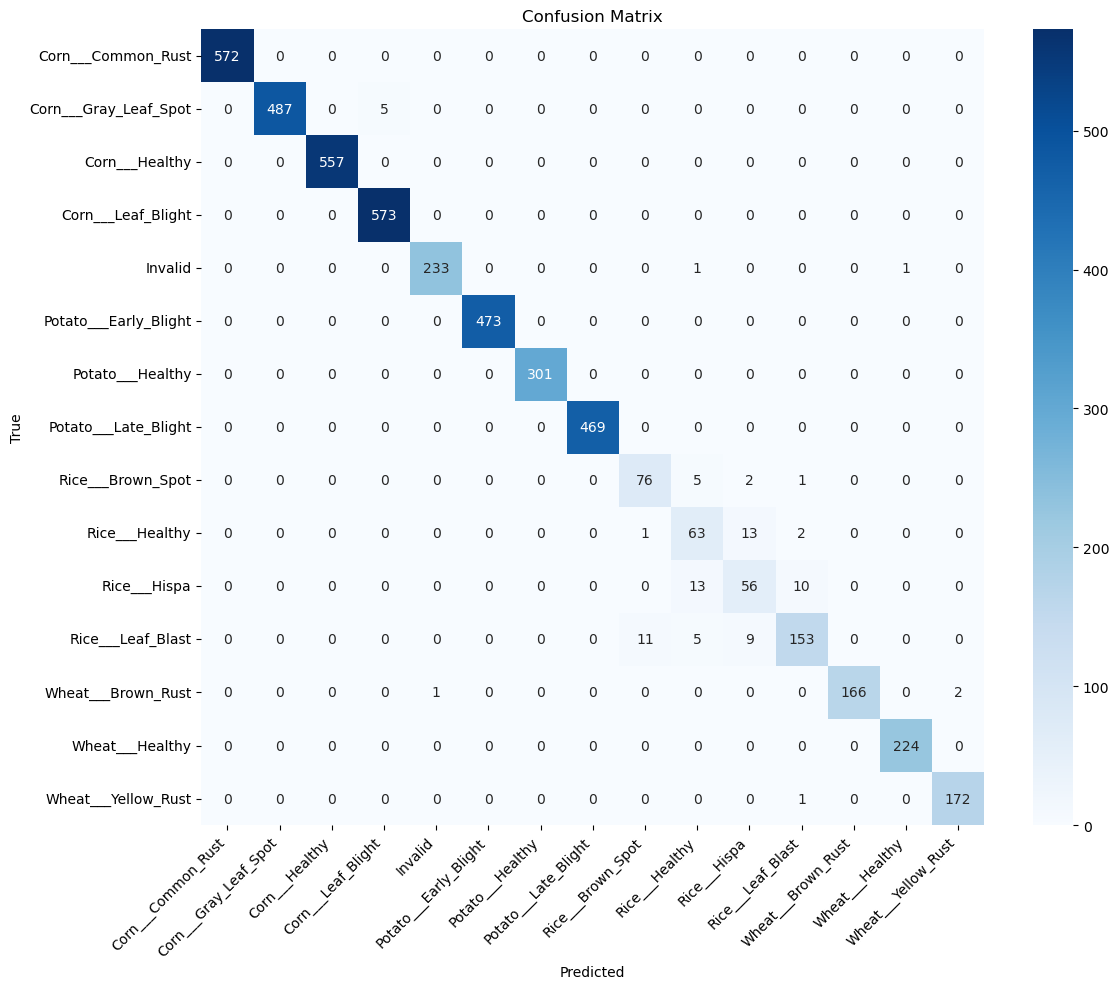

In [34]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Evaluate best model
try:
    model.load_state_dict(torch.load(best_model_path, weights_only=True))
except FileNotFoundError:
    raise FileNotFoundError(f"Best model not found at {best_model_path}")
except Exception as e:
    raise RuntimeError(f"Failed to load model from {best_model_path}: {e}")

model.eval()
total_test_loss = 0
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in full_test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute metrics
avg_test_loss = total_test_loss / len(full_test_loader)
test_accuracy = 100 * correct / total
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
f1_per_class = f1_score(all_labels, all_preds, average=None)
class_names = full_dataset.class_names  # From CropDataset

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Print metrics
print(f"Final Evaluation Results | "
      f"Test Loss: {avg_test_loss:.4f} | "
      f"Accuracy: {test_accuracy:.2f}% | "
      f"Precision: {precision:.4f} | Recall: {recall:.4f} | F1 Score: {f1:.4f}")
print("\nPer-class F1 Scores:")
for class_name, f1_score in zip(class_names, f1_per_class):
    print(f"{class_name}: {f1_score:.4f}")

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

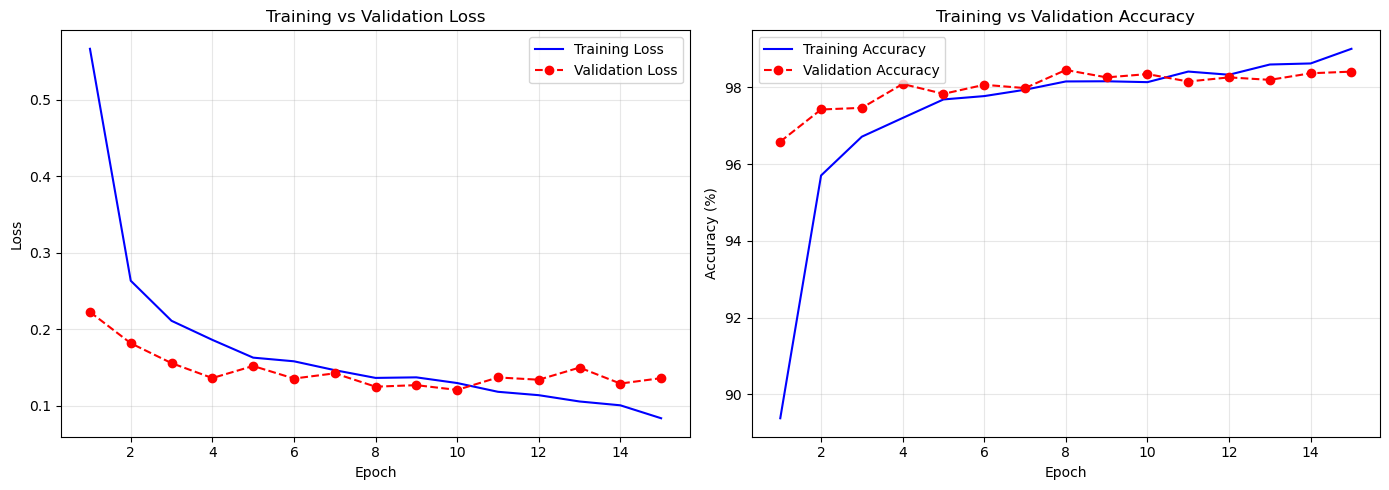

In [35]:
# Plotting: Training vs Validation Loss and Accuracy side by side
completed_epochs = len(train_losses)
epochs = list(range(1, completed_epochs + 1))

plt.figure(figsize=(14, 5))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(alpha=0.3)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red', marker='o', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

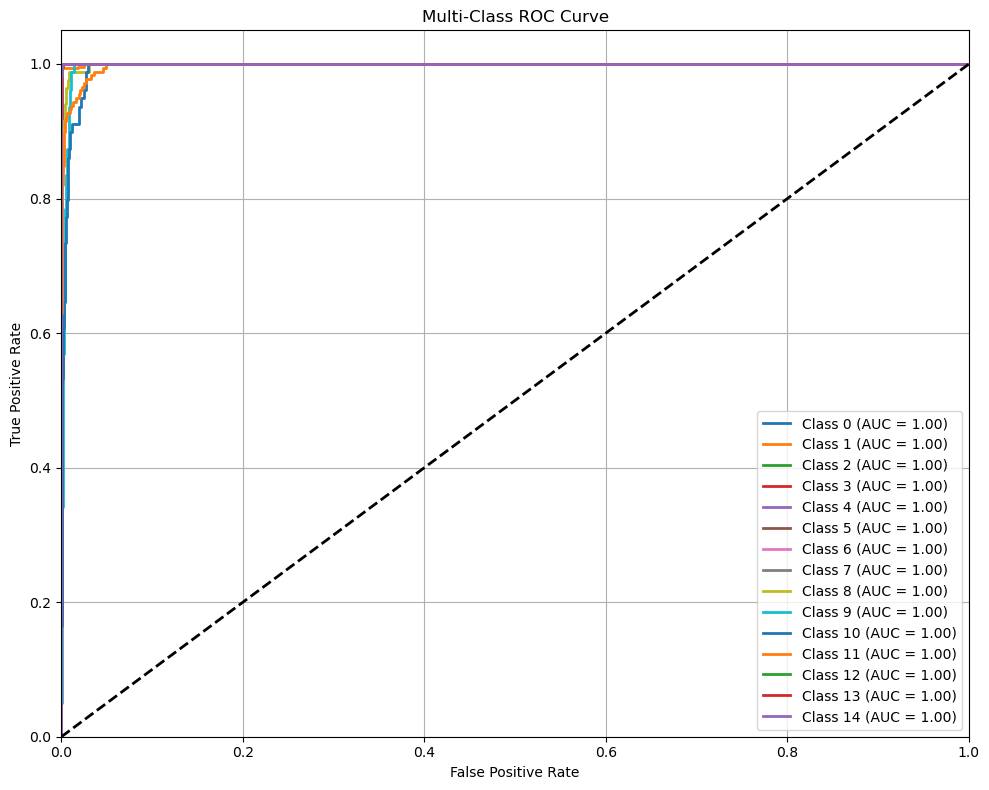

In [36]:
# ROC curve

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Assuming num_class is defined (number of classes)
# And all_labels, all_preds already collected

# 1. Get probabilities
all_probs = []

model.eval()
with torch.no_grad():
    for images, labels in full_test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

# 2. Binarize labels for multi-class ROC
all_labels_bin = label_binarize(all_labels, classes=list(range(num_class)))
all_probs = np.array(all_probs)

# 3. Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(num_class):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 4. Plot
plt.figure(figsize=(10, 8))
for i in range(num_class):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
# Assuming you already created the test_dataset using random_split

# Access the dataset inside the Subset object
test_image_paths = [test_dataset.dataset.image_paths[i] for i in test_dataset.indices[:30]]

# Print image paths
for idx, path in enumerate(test_image_paths):
    print(f"Image {idx+1}: {path}")

Image 1: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Early_Blight\655010d0-0bf7-4cba-8ebe-591a8bc5f552___RS_Early.B 7668_flipTB.JPG
Image 2: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Leaf_Blight\7348d45f-96ba-454e-b0eb-084d0284f718___RS_NLB 4242(1).JPG
Image 3: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Late_Blight\98a806fd-2839-4069-b40b-08522c34ccdc___RS_LB 3032.JPG
Image 4: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Rice___Leaf_Blast\IMG_4853.jpg
Image 5: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Leaf_Blight\ec769dd1-532c-4f81-b677-6b7b4d0d7606___RS_NLB 4140_180deg(1).JPG
Image 6: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Healthy\b7214149-73ad-481e-9227-c9fe77f10477___R.S_HL 7896 copy 2.jpg
Image 7: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Gray_Leaf_Spot\2ccec9ab-60e1-4b79-bfdc-b33d387db907___RS_GLSp 4576_90deg.JPG
Image 8: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Invalid\flower_0048.jpg
Image 9: D:\DOCS\PYTHON\CropDisease\Crop___DIsease\R

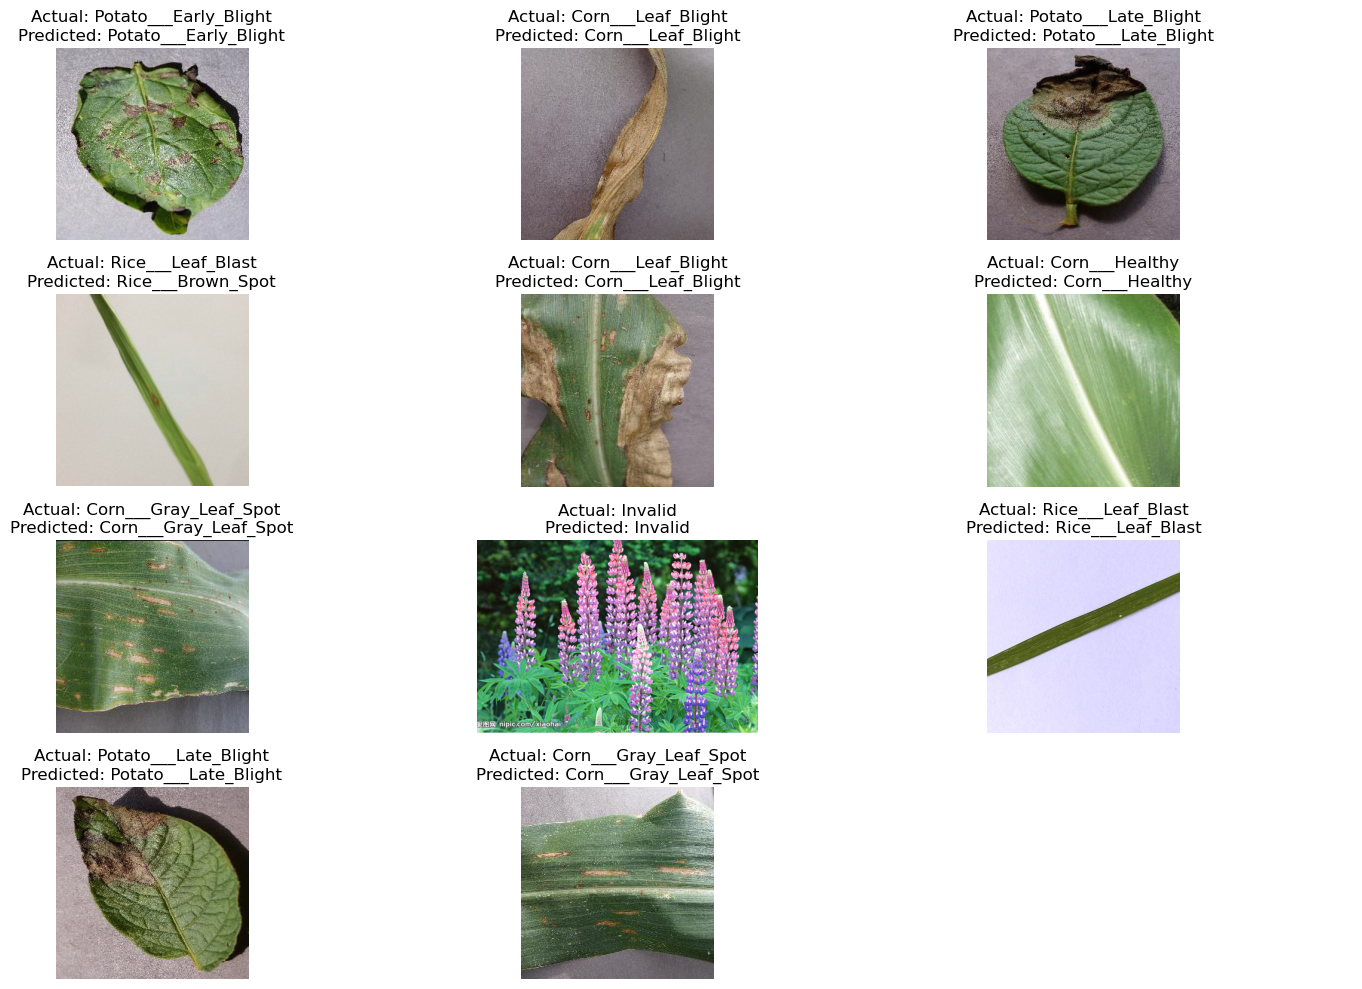

In [38]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os

# ---------------------------
# Configuration
# ---------------------------

# Sample multiple image paths (adjust the paths as needed)
image_paths = [
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Early_Blight\655010d0-0bf7-4cba-8ebe-591a8bc5f552___RS_Early.B 7668_flipTB.JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Leaf_Blight\7348d45f-96ba-454e-b0eb-084d0284f718___RS_NLB 4242(1).JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Late_Blight\98a806fd-2839-4069-b40b-08522c34ccdc___RS_LB 3032.JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Rice___Leaf_Blast\IMG_4853.jpg',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Leaf_Blight\ec769dd1-532c-4f81-b677-6b7b4d0d7606___RS_NLB 4140_180deg(1).JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Healthy\b7214149-73ad-481e-9227-c9fe77f10477___R.S_HL 7896 copy 2.jpg',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Gray_Leaf_Spot\2ccec9ab-60e1-4b79-bfdc-b33d387db907___RS_GLSp 4576_90deg.JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Invalid\flower_0048.jpg',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Rice___Leaf_Blast\IMG_20190419_110208.jpg',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Late_Blight\53e33b6d-9fc5-441b-b638-3bf067f92a99___RS_LB 2753.JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Gray_Leaf_Spot\3c53ba48-cb78-4803-b01c-7d10ea13284c___RS_GLSp 4611_90deg.JPG',
]


# Load your model here
# model = YourModelClass(...)
# model.load_state_dict(torch.load("your_model_path.pth"))
model.to(device)
model.eval()


# ---------------------------
# Helper functions
# ---------------------------

def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize for VGG/ResNet input
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

def get_actual_class(image_path):
    return os.path.basename(os.path.dirname(image_path))

# ---------------------------
# Prediction and Display
# ---------------------------

# Set up the subplot grid
n_images = len(image_paths)
cols = 3
rows = (n_images + cols - 1) // cols  # Calculate number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for idx, image_path in enumerate(image_paths):
    actual_class = get_actual_class(image_path)
    image_tensor = load_and_preprocess_image(image_path).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class = crop_class_map[predicted_idx.item()]
    
    # Reopen image for display (no transformation)
    img_display = Image.open(image_path)
    
    # Display image and prediction
    axes[idx].imshow(img_display)
    axes[idx].set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    axes[idx].axis('off')

# Hide any remaining axes if the number of images is less than the grid size
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

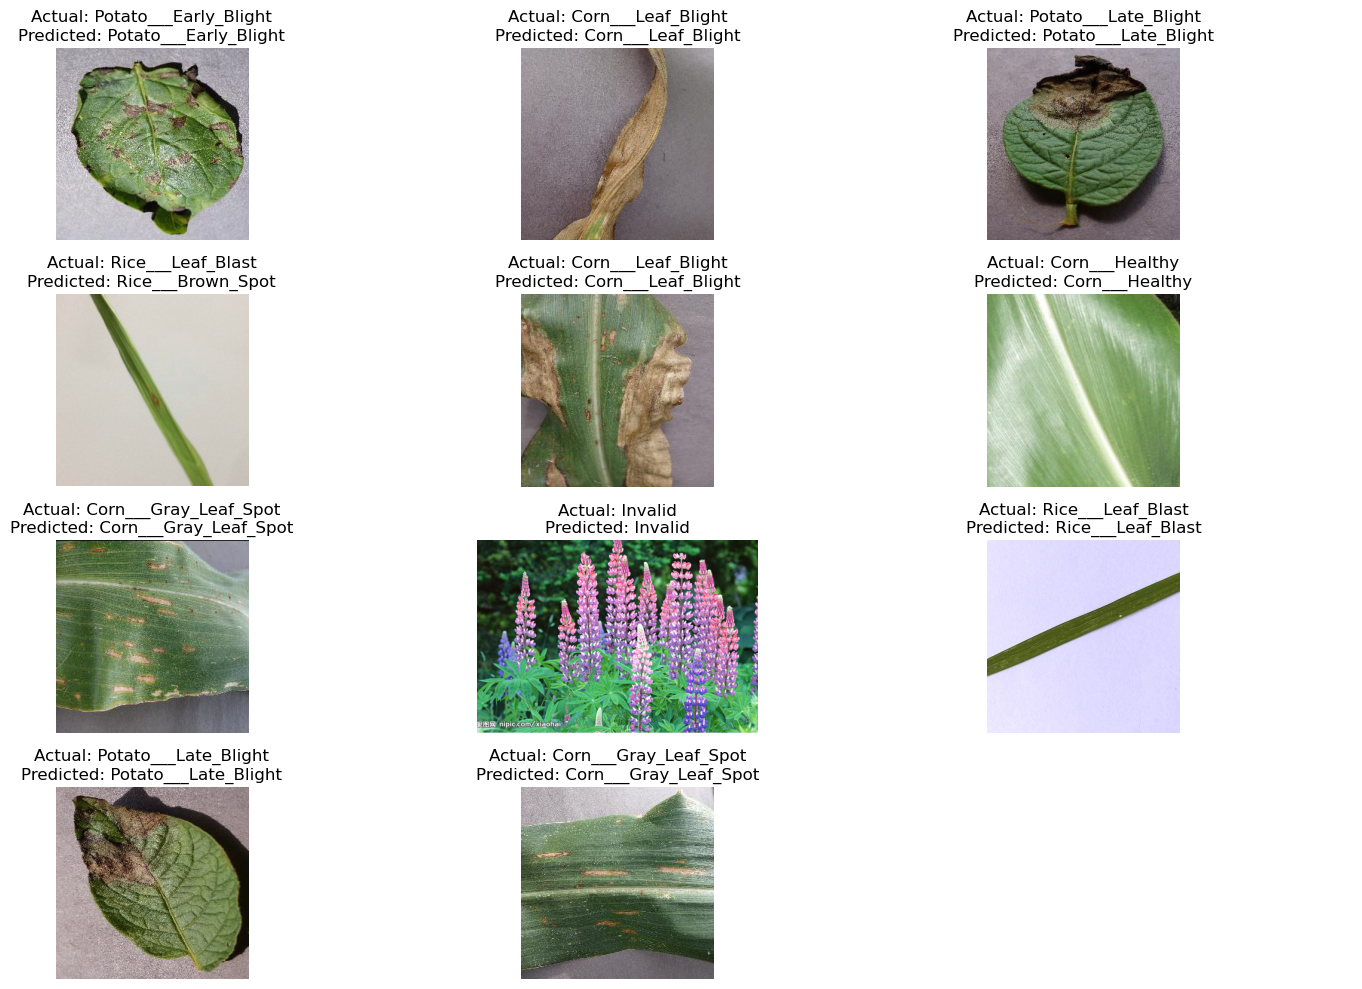

In [40]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os

# ---------------------------
# Configuration
# ---------------------------

# Sample multiple image paths (adjust the paths as needed)
image_paths = [
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Early_Blight\655010d0-0bf7-4cba-8ebe-591a8bc5f552___RS_Early.B 7668_flipTB.JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Leaf_Blight\7348d45f-96ba-454e-b0eb-084d0284f718___RS_NLB 4242(1).JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Late_Blight\98a806fd-2839-4069-b40b-08522c34ccdc___RS_LB 3032.JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Rice___Leaf_Blast\IMG_4853.jpg',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Leaf_Blight\ec769dd1-532c-4f81-b677-6b7b4d0d7606___RS_NLB 4140_180deg(1).JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Healthy\b7214149-73ad-481e-9227-c9fe77f10477___R.S_HL 7896 copy 2.jpg',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Gray_Leaf_Spot\2ccec9ab-60e1-4b79-bfdc-b33d387db907___RS_GLSp 4576_90deg.JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Invalid\flower_0048.jpg',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Rice___Leaf_Blast\IMG_20190419_110208.jpg',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Potato___Late_Blight\53e33b6d-9fc5-441b-b638-3bf067f92a99___RS_LB 2753.JPG',
    r'D:\DOCS\PYTHON\CropDisease\Crop___DIsease\Corn___Gray_Leaf_Spot\3c53ba48-cb78-4803-b01c-7d10ea13284c___RS_GLSp 4611_90deg.JPG',
]


# Load your model here
# model = YourModelClass(...)
# model.load_state_dict(torch.load("your_model_path.pth"))
model.to(device)
model.eval()


# ---------------------------
# Helper functions
# ---------------------------

def load_and_preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize for VGG/ResNet input
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # Add batch dimension

def get_actual_class(image_path):
    return os.path.basename(os.path.dirname(image_path))

# ---------------------------
# Prediction and Display
# ---------------------------

# Set up the subplot grid
n_images = len(image_paths)
cols = 3
rows = (n_images + cols - 1) // cols  # Calculate number of rows

fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
axes = axes.flatten()

for idx, image_path in enumerate(image_paths):
    actual_class = get_actual_class(image_path)
    image_tensor = load_and_preprocess_image(image_path).to(device)
    
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted_idx = torch.max(outputs, 1)
        predicted_class = crop_class_map[predicted_idx.item()]
    
    # Reopen image for display (no transformation)
    img_display = Image.open(image_path)
    
    # Display image and prediction
    axes[idx].imshow(img_display)
    axes[idx].set_title(f"Actual: {actual_class}\nPredicted: {predicted_class}")
    axes[idx].axis('off')

# Hide any remaining axes if the number of images is less than the grid size
for j in range(idx + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()